# 1. Designing our experiment

### The sample size we need is estimated through something called Power analysis, and it depends on a few factors:

##### The sample size we need is estimated through something called Power analysis, and it depends on a few factors:
##### Alpha value (α) — The critical value we set earlier to 0.05
##### Effect size — How big of a difference we expect there to be between the conversion rates

##### Since our team would be happy with a difference of 10%, we can use 13% and 23% to calculate the effect size we expect.

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [2]:
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
effect_size = sms.proportion_effectsize(0.13, 0.23)    # Calculating effect size based on our expected rates
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.00001, ratio=1)                                                  # Calculating sample size needed
required_n = ceil(required_n);required_n                         # Rounding up to next whole number                          

802

In [3]:
from statsmodels.stats.power import TTestIndPower# parameters for power analysis # effect_size has to be positive
effect = 0.1
alpha = 0.00001
power = 0.8 # perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(effect, power = power, nobs1= None, ratio = 1.0, alpha = alpha)
print('Sample Size: %.3f' % round(result))

Sample Size: 5536.000


##### Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [4]:
df = pd.read_excel(r'ResweldAB.xlsx')

df.head()

,PN_133501070_Result_Left_SinkInPoint,AI Enabled
0,310.0000,0
1,331.0000,0
2,329.1992,0
3,324.9990,0
4,329.0996,0


In [5]:
df['PartStatus'] = 0

In [6]:
df.loc[((df.PN_133501070_Result_Left_SinkInPoint >= 325) & (df.PN_133501070_Result_Left_SinkInPoint <= 375)) , "PartStatus"] = 1

In [7]:
df['PartStatus'].value_counts()

1    97292
0     9938
Name: PartStatus, dtype: int64

In [8]:
df.head()

,PN_133501070_Result_Left_SinkInPoint,AI Enabled,PartStatus
0,310.0000,0,0
1,331.0000,0,1
2,329.1992,0,1
3,324.9990,0,0
4,329.0996,0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107230 entries, 0 to 107229
Data columns (total 3 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   PN_133501070_Result_Left_SinkInPoint  107230 non-null  float64
 1   AI Enabled                            107230 non-null  int64  
 2   PartStatus                            107230 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.5 MB


### Column Definitions

#####  	PN_133501070_Result_Left_SinkInPoint 
#####   AI Enabled : AI was on 
#####   In Limits= 0 -- no || 1 -->yes PartStatus

In [10]:
df.head()

,PN_133501070_Result_Left_SinkInPoint,AI Enabled,PartStatus
0,310.0000,0,0
1,331.0000,0,1
2,329.1992,0,1
3,324.9990,0,0
4,329.0996,0,1


### Sampling

In [11]:
control_sample = df[df['AI Enabled'] == 1].sample(n=required_n, random_state=22)
treatment_sample = df[df['AI Enabled'] == 0].sample(n=required_n, random_state=22)
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [12]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PN_133501070_Result_Left_SinkInPoint  1604 non-null   float64
 1   AI Enabled                            1604 non-null   int64  
 2   PartStatus                            1604 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 37.7 KB


In [13]:
ab_test['AI Enabled'].value_counts()

1    802
0    802
Name: AI Enabled, dtype: int64

In [14]:
ab_test_index = ab_test.reset_index()

### 3. Visualising the results

In [15]:
conversion_rates = ab_test.groupby('AI Enabled')['PartStatus']
std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
AI Enabled,,,
0,0.855,0.352,0.012
1,0.983,0.131,0.005


##### Judging by the stats above, it does look like our two designs performed very similarly, with our new design performing slightly better, approx. 84.8% vs. 98.3% conversion rate.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


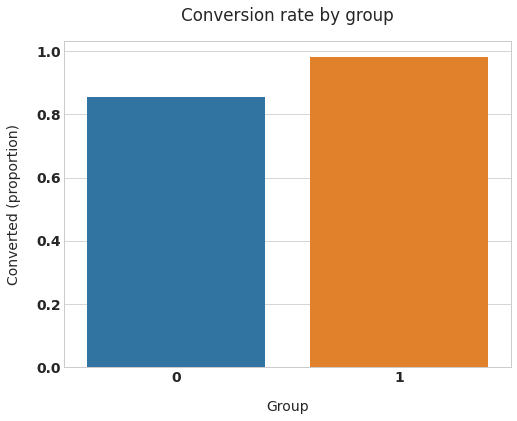

In [16]:
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['AI Enabled'], y=ab_test['PartStatus'], ci=False)
plt.title('Part rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

##### So… the treatment group's value is higher. Is this difference statistically significant?

### Testing the hypothesis

In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['AI Enabled'] == 0]['PartStatus']
treatment_results = ab_test[ab_test['AI Enabled'] == 1]['PartStatus']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -9.33
p-value: 0.000
ci 95% for control group: [0.831, 0.880]
ci 95% for treatment group: [0.973, 0.992]


##### Since our p-value=0.000 is way below our α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new design perform significantly better than our old one